In [1]:
# Import all Packages
import ast
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches

%matplotlib inline
%config InlineBackend.figure_format='retina'


output_dir = "output_heatmap"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

organelles = ['ER', 'Golgi', 'actin', 'bud_neck', 'cell_periphery', 'cytoplasm',
        'endosome', 'lipid_particle', 'mitochondria', 'none',
        'nuclear_periphery', 'nucleolus', 'nucleus', 'peroxisome',
        'spindle_pole', 'vacuolar_membrane', 'vacuole']

In [2]:
min_num_proteins = 3

df = pd.read_excel('../data/Standard_name_vs_system_name.xlsx', header=None)
unknown_strains = list(df[1].values)

strain_loc = pd.read_csv("../data/finer_agebins_strainlevel_prob_allages_none06.csv")
prob_all_ages = strain_loc.copy()
strain_loc = strain_loc[strain_loc['grouped_n_scar']=='stage_0_young']

selected_strains = pd.read_csv("../data/3575_celllevel_drop_strains_complex_discovery_young.csv")
selected_strains = set(selected_strains['strain'].unique())
strain_loc['grouped_n_scar'] = 'young'
strain_loc = strain_loc[strain_loc['strain'].isin(selected_strains)]
screened_strains = list(strain_loc['strain'].unique())

complex_strain_map = pd.read_csv("../data/protein_complexes_strains_map.csv")
complex_strain_map['Gene_Names'] = complex_strain_map['Gene_Names'].apply(ast.literal_eval)
complex_strain_map['Gene_Names'] = complex_strain_map['Gene_Names'].apply(
    lambda genes: [g for g in genes if g in screened_strains])

gene_to_localization = dict(zip(strain_loc['strain'], strain_loc['avg_prediction']))

complex_strain_map['Gene_Localizations'] = complex_strain_map['Gene_Names'].apply(
    lambda genes: [gene_to_localization.get(g, 'unknown') for g in genes])

def get_localization_percentages(localizations):
    total = len(localizations)
    counts = Counter(localizations)
    return {loc: round((count / total) * 100, 2) for loc, count in counts.items()}


complex_strain_map['Localization_Percentages'] = complex_strain_map['Gene_Localizations'].apply(get_localization_percentages)


other_columns = ['gfp_image_names', 'mask_image_names', 'cw_well_names', 'combined',
                 'ensemble_pred', 'true_labels', 'preds','strain', 'top1_label', '2d_true_labels', '2d_preds', '3d_true_labels',
                 '3d_preds',
                '3d_gfp_image_names',
                '3d_mask_image_names',
                '3d_cw_well_names',
                '3d_combined',
                'young_img_well',
                'plate_name', 'ensemble_pred',
                'true_labels',
                'gfp_image_names',
                'cw_well_names',
                'combined',
                'old_img_well',
                'plate_name',
                'strain',
                'top1_label',
                'n_scar',
                'grouped_n_scar',
                'organell_intensity_yen_sum',
                'cyto_intensity_yen_sum',
                'organell_mask3D_yen_sum',
                'cyto_mask3D_yen_sum',
                'organell_intensity_yen_mean',
                'cyto_intensity_yen_mean',
                'organell_area_percent_yen',
                'organell_vs_cyto_yen', 'scar_group', 'index', 'avg_prediction']

In [3]:
df_within_across_strain = pd.read_parquet("../data/3592young_wholeproteome_strains_correct_all_110_validate_literature.parquet")

pca_columns = [i for i in list(df_within_across_strain) if i not in organelles+other_columns]
features= pca_columns+organelles

df_within_across_strain['strain'].nunique()
prob_young_age = prob_all_ages[prob_all_ages['grouped_n_scar']=='stage_0_young']
all_strains = prob_young_age[prob_young_age['strain'].isin(list(df_within_across_strain['strain'].unique()))]
none_strains = list(all_strains[all_strains['top1_label']=='none']['strain'].unique())
df_within_across_strain = df_within_across_strain[~df_within_across_strain['strain'].isin(none_strains)]

### Each Strain considered must have minimum 20 cells
dd = df_within_across_strain
group_counts = (dd.groupby(['strain', 'grouped_n_scar']).size().reset_index(name='count'))
filtered_groups = group_counts[group_counts['count'] > 20][['strain', 'grouped_n_scar']]
df_filtered = dd.merge(filtered_groups, on=['strain', 'grouped_n_scar'], how='inner')

In [4]:
complex_strain_map['num_protein_in_complx'] = complex_strain_map['Gene_Names'].apply(lambda x: len(x))
only_complx_withmin_3strains = complex_strain_map[complex_strain_map['num_protein_in_complx']>2]
complx_strains = [i for sublist in list(only_complx_withmin_3strains['Gene_Names']) for i in sublist]
complx_strains = list(set(complx_strains))

print(len(only_complx_withmin_3strains))
strains_tobe_removed = set(complx_strains)-set(df_filtered['strain'].unique())
print(strains_tobe_removed)
afterremoval = []
for i in list(only_complx_withmin_3strains['Gene_Names']):
    afterremoval.append([s for s in i if s not in strains_tobe_removed])

only_complx_withmin_3strains['Gene_Names'] = afterremoval
complex_strain_map['num_protein_in_complx'] = complex_strain_map['Gene_Names'].apply(lambda x: len(x))
only_complx_withmin_3strains = complex_strain_map[complex_strain_map['num_protein_in_complx']>2]
print("Complexes with minimum 3 strains", len(only_complx_withmin_3strains))

protein_complex_strains_map = dict(zip(only_complx_withmin_3strains['Recommended name'], only_complx_withmin_3strains['Gene_Names']))
dd = df_filtered.copy()

dd = (dd.groupby('strain', group_keys=False)
          .apply(lambda g: g.sample(min(len(g), 200), # ≤200 rows
                                    random_state=0,
                                    replace=False)))

pca_df_cell_level = dd[pca_columns+['strain']]
print(f"Number of strains for performing strain similarity: {pca_df_cell_level['strain'].nunique()}")

150
{'PAP1', 'SLD3', 'RFC5', 'PEX14', 'RSC1', 'CUL3', 'REF2'}
Complexes with minimum 3 strains 150


/tmp/ipykernel_3749052/790028409.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_complx_withmin_3strains['Gene_Names'] = afterremoval


Number of strains for performing strain similarity: 3432


/tmp/ipykernel_3749052/790028409.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(len(g), 200), # ≤200 rows


### Strain–Strain Correlation Clustering and Visualization

In [5]:
# ============================================================
# Strain–Strain Correlation Clustering and Visualization
# ============================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages

# ============================================================
# 1) Collapse cells -> strain means
# ============================================================
strain_stats = (
    pca_df_cell_level
    .groupby("strain")[pca_columns]
    .agg(['mean'])
)
strain_means = strain_stats.xs('mean', axis=1, level=1)

# ============================================================
# 2) Strain–strain correlation and clustering
# ============================================================
corr = strain_means.T.corr(method='pearson')
corr = corr.fillna(0.0).clip(0, 1)  # keep in [0,1]

dist = 1.0 - corr
condensed = squareform(dist.values, checks=False)
link = linkage(condensed, method='average')
order = leaves_list(link)

# reorder correlation matrix by cluster order
corr_clustered = corr.iloc[order, :].iloc[:, order]

# ============================================================
# 3) Row colors by complex (optional strip)
# ============================================================
strain_to_complex = {}
for cpx, strains in protein_complex_strains_map.items():
    for s in strains:
        strain_to_complex.setdefault(s, cpx)

top_complexes = (
    pd.Series(strain_to_complex)
      .value_counts()
      .head(15)
      .index
      .tolist()
)
palette = sns.color_palette("tab20", n_colors=len(top_complexes))
cpx2color = {c:px for c, px in zip(top_complexes, palette)}
default_color = (0.85, 0.85, 0.85)
row_colors = [cpx2color.get(strain_to_complex.get(s), default_color) for s in corr_clustered.index]

# ============================================================
# 4) Bright red colormap
# ============================================================
cmap = LinearSegmentedColormap.from_list(
    "softReds", [(1,1,1), (1,0.85,0.85), (0.8,0.0,0.0)], N=256
)

# ============================================================
# 5) Plot heatmap (no dendrograms)
# ============================================================
sns.set_theme(style="white")
sns.set_context("talk")

fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(
    corr_clustered,
    cmap=cmap,
    vmin=-0.3, vmax=0.85,
    square=True,
    xticklabels=False, yticklabels=False,
    cbar_kws={"label": "Pearson correlation", "shrink": 0.4},
    linewidths=0,
    ax=ax
)

# --- Add row color strip ---
for y, color in enumerate(row_colors):
    ax.add_patch(plt.Rectangle(
        (-0.5, y-0.5), -0.3, 1, color=color, lw=0
    ))

# --- Style colorbar ---
cbar = ax.collections[0].colorbar
cbar.outline.set_visible(False)
cbar.set_ticks([0, 0.8])
cbar.set_ticklabels(["0", "1"], weight="bold", fontsize=10)
cbar.ax.yaxis.label.set_size(10)
cbar.ax.yaxis.label.set_fontweight("bold")

# --- Add border around heatmap ---
n = corr_clustered.shape[0]
border = plt.Rectangle(
    (-0.5, -0.5), n, n,
    fill=False, edgecolor="grey", linewidth=4
)
ax.add_patch(border)

# --- Labels and title ---
ax.set_xlabel("Strain", fontsize=10, fontweight="bold", labelpad=8)
ax.set_ylabel("Strain", fontsize=10, fontweight="bold", labelpad=8)
plt.title("Strain–strain similarity (clustered)", fontsize=11, pad=10, weight='bold')

plt.tight_layout()

# ============================================================
# ✅ Fast PDF saving (rasterized heatmap)
# ============================================================
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("./output_heatmap/strain_similarity_clustered.pdf") as pdf:
    # Rasterize only the heatmap (keep axes/text as vector)
    for coll in ax.collections:
        coll.set_rasterized(True)

    fig.canvas.draw()
    pdf.savefig(fig, bbox_inches="tight", dpi=300)
    plt.close(fig)

print("Saved quickly (rasterized): strain_similarity_clustered.pdf")
plt.show()


Saved quickly (rasterized): strain_similarity_clustered.pdf


### Protein Complex Correlation Strength Analysis

✅ Saved: complex_correlation_curve.pdf


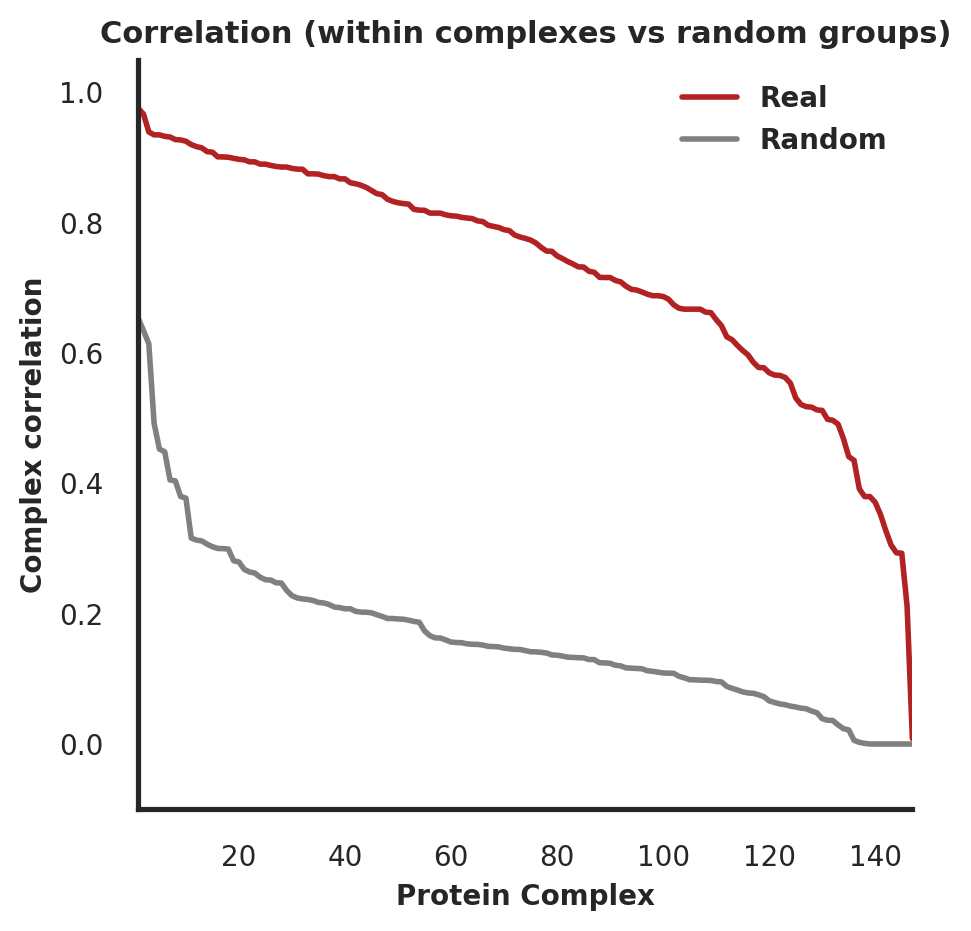

In [6]:
# ============================================================
# Helpers
# ============================================================
def complex_score(corr_df: pd.DataFrame, members: list[str], stat="median"):
    """Pairwise correlation summary for a set of members present in corr_df."""
    m = [s for s in members if s in corr_df.index]
    if len(m) < 3:
        return np.nan
    vals = [corr_df.loc[i, j] for i, j in combinations(m, 2)]
    if not vals:
        return np.nan
    vals = np.array(vals, dtype=float)
    if stat == "median":
        return np.nanmedian(vals)
    elif stat == "mean":
        return np.nanmean(vals)
    else:
        raise ValueError("stat must be 'median' or 'mean'.")

def sample_group_scores(corr_df, sizes, n_reps=1, stat="mean", rng=None):
    """Generate size-matched random scores for null comparison."""
    if rng is None:
        rng = np.random.default_rng(42)
    all_strains = np.array(corr_df.index.tolist())
    scores = []
    for k in sizes:
        if k < 2 or k > len(all_strains):
            scores.append(np.nan)
            continue
        for _ in range(n_reps):
            grp = rng.choice(all_strains, size=k, replace=False)
            scores.append(complex_score(corr_df, grp.tolist(), stat=stat))
    return np.array(scores, dtype=float)

# ============================================================
# 1) Filter complexes present in correlation matrix
# ============================================================
present = set(corr.index)
complex_members = {
    cpx: [s for s in slist if s in present]
    for cpx, slist in protein_complex_strains_map.items()
}
complex_members = {cpx: mem for cpx, mem in complex_members.items() if len(mem) > 2}

# ============================================================
# 2) Real complex correlation scores
# ============================================================
real_scores, real_sizes, real_names = [], [], []
for cpx, mem in complex_members.items():
    sc = complex_score(corr, mem, stat="mean")
    if np.isfinite(sc):
        real_scores.append(sc)
        real_sizes.append(len(mem))
        real_names.append(cpx)

real_scores = np.array(real_scores, dtype=float)
real_sizes = np.array(real_sizes, dtype=int)

# ============================================================
# 3) Random control scores
# ============================================================
if len(real_scores) == 0:
    print("No complexes with ≥2 members found in the correlation matrix.")
else:
    rand_scores = sample_group_scores(corr, real_sizes, n_reps=1, stat="mean")

    # ========================================================
    # 4) Plot ranked correlation curve
    # ========================================================
    real_sorted = np.sort(real_scores)[::-1]
    rand_sorted = np.sort(rand_scores)[::-1]

    plt.figure(figsize=(5, 5))
    plt.plot(
        np.arange(1, len(real_sorted) + 1),
        real_sorted,
        lw=2, label="Real", color="#B22222"
    )
    plt.plot(
        np.arange(1, len(rand_sorted) + 1),
        rand_sorted,
        lw=2, label="Random", color="gray"
    )

    plt.xlabel("Protein Complex", fontsize=10, weight="bold")
    plt.ylabel("Complex correlation", fontsize=10, weight="bold")
    plt.ylim(-0.1, 1.05)
    plt.xlim(1, len(real_sorted))
    plt.title("Correlation (within complexes vs random groups)", fontsize=11, weight="bold")

    plt.tick_params(axis="x", labelsize=10)
    plt.tick_params(axis="y", labelsize=10)
    plt.legend(frameon=False, prop={"size": 10, "weight": "bold"})
    plt.tight_layout()
    sns.despine()

    # ========================================================
    # ✅ Fixed save as PDF (non-empty) + show inline
    # ========================================================
    fig = plt.gcf()
    with PdfPages("./output_heatmap/complex_correlation_curve.pdf") as pdf:
        fig.canvas.draw()  # ensure fully rendered before saving
        pdf.savefig(fig, bbox_inches="tight", dpi=300)
        # keep figure open for inline display

    print("✅ Saved: complex_correlation_curve.pdf")

    # --- Show the same figure inline ---
    plt.show()


### Automated Extraction of Protein Complex Regions from Correlation Matrix

In [7]:

def plot_all_complexes_to_pdf(
    corr,
    protein_complex_strains_map,
    save_pdf_path="selected_complex_regions.pdf",
    selected_complexes=None,
    min_size=3,
    base_size=0.45,
    min_figsize=5.0,
    max_figsize=12.0,
    dpi=300
):
    """
    Generate and save zoomed heatmaps for specific or all complexes into a single multi-page PDF.
    - If `selected_complexes` is provided, only those complexes are plotted.
    - If None, all complexes meeting min_size are plotted.
    """

    pdf = PdfPages(save_pdf_path)
    plotted = 0

    for complex_name, members in protein_complex_strains_map.items():
        # --- Skip complexes not in selection (if given) ---
        if selected_complexes is not None and complex_name not in selected_complexes:
            continue

        # --- Filter members present in correlation matrix ---
        complex_members = [s for s in members if s in corr.index]
        if len(complex_members) < min_size:
            continue

        # --- Determine region bounds (exact span) ---
        idx_positions = [corr.index.get_loc(s) for s in complex_members]
        start, end = min(idx_positions), max(idx_positions)
        sub = corr.iloc[start:end+1, start:end+1]
        strains = sub.index
        is_member = [s in complex_members for s in strains]

        # --- Figure size based on number of strains ---
        n = len(strains)
        fig_size = max(min_figsize, min(max_figsize, n * base_size))

        # --- Colormap ---
        cmap = LinearSegmentedColormap.from_list(
            "softReds", [(1,1,1), (1,0.85,0.85), (0.9,0.1,0.1)], N=256
        )

        sns.set(style="white", context="talk")
        fig, ax = plt.subplots(figsize=(fig_size, fig_size))
        sns.heatmap(
            sub,
            cmap=cmap,
            vmin=0, vmax=1,
            square=True,
            xticklabels=True, yticklabels=True,
            cbar=False,
            linewidths=0,
            ax=ax
        )

        # --- Highlight borders ---
        for i, s in enumerate(strains):
            edge_col = 'crimson' if is_member[i] else 'lightgray'
            lw = 2.0 if is_member[i] else 0.7
            ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor=edge_col, lw=lw, zorder=10))

        # --- Label colors ---
        for label, member in zip(ax.get_xticklabels(), is_member):
            label.set_color('black' if member else 'gray')
            label.set_rotation(90)
            label.set_ha("center")

        for label, member in zip(ax.get_yticklabels(), is_member):
            label.set_color('black' if member else 'gray')

        # --- Title ---
        ax.set_title(f"{complex_name} (n={len(complex_members)})", weight='bold', pad=10)
        plt.tight_layout()

        pdf.savefig(fig, bbox_inches="tight", dpi=dpi)
        plt.close(fig)
        plotted += 1

    pdf.close()
    print(f"Saved {plotted} complex region plots to {save_pdf_path}")

selected = ['Septin complex', 'COPI vesicle coat complex', 'Casein kinase II complex, CKA1 variant', 'Cytoplasmic exosome complex, DIS3 variant', 'Nuclear pore complex', 'DASH complex', 'Nuclear/nucleolar exosome complex, DIS3-RRP6 variant']
plot_all_complexes_to_pdf(
    corr=corr_clustered,
    protein_complex_strains_map=protein_complex_strains_map,
    save_pdf_path="./output_heatmap/selected_complexes.pdf",
    selected_complexes=selected
)

Saved 7 complex region plots to ./output_heatmap/selected_complexes.pdf


### Plot Complexes

In [8]:
import os
from matplotlib.colors import LinearSegmentedColormap

def plot_complex_heatmaps(
    corr: pd.DataFrame,
    protein_complex_strains_map: dict[str, list[str]],
    min_size: int = 3,
    save_pdf_path: str | None = None,
    vmin: float = 0.0,
    vmax: float = 1.0,
    case_insensitive: bool = True,   # sort tick labels A→Z (case-insensitive)
):
    """
    Make a heatmap for each complex present in `corr`, with tick labels sorted A→Z.
    No clustering, labels sorted alphabetically, and no colorbar.
    """
    from matplotlib.backends.backend_pdf import PdfPages
    import seaborn as sns
    import matplotlib.pyplot as plt

    in_matrix = set(corr.index)
    complex_to_strains = {
        cpx: [s for s in slist if s in in_matrix]
        for cpx, slist in protein_complex_strains_map.items()
    }
    complex_to_strains = {cpx: sl for cpx, sl in complex_to_strains.items() if len(sl) >= min_size}
    if not complex_to_strains:
        print(f"No complexes with ≥{min_size} members found in the correlation matrix.")
        return

    pdf = PdfPages(save_pdf_path) if save_pdf_path else None
    sns.set_context("talk")

    for cpx, strains in sorted(complex_to_strains.items(), key=lambda kv: (-len(kv[1]), kv[0])):
        sub = corr.loc[strains, strains]

        # --- sort labels A→Z ---
        keyfn = (lambda x: str(x).lower()) if case_insensitive else (lambda x: str(x))
        idx = sorted(sub.index, key=keyfn)
        sub = sub.loc[idx, idx]

        # scale figure size with group size
        n = sub.shape[0]
        size_per_strain = 0.40
        fig_size = max(7, n * size_per_strain)

        g = sns.clustermap(
            sub,
            row_cluster=False,
            col_cluster=False,
            cmap=LinearSegmentedColormap.from_list(
                "softReds", [(1,1,1), (1,0.85,0.85), (0.9,0.1,0.1)], N=256
            ),
            vmin=vmin, vmax=vmax,
            linewidths=0,
            xticklabels=True, yticklabels=True,
            figsize=(fig_size, fig_size),
            cbar=False   # 🚫 no colorbar
        )

        # Labels
        g.ax_heatmap.set_title(f"{cpx}  (n={n})", pad=14)
        g.ax_heatmap.set_xlabel("strain")
        g.ax_heatmap.set_ylabel("strain")
        for lbl in g.ax_heatmap.get_xticklabels():
            lbl.set_rotation(90)
            lbl.set_ha("center")

        if g.cax is not None:
            g.cax.set_visible(False)

        plt.tight_layout()
        if pdf is not None:
            pdf.savefig(g.fig, bbox_inches="tight")
            plt.close(g.fig)
        else:
            plt.show()

    if pdf is not None:
        pdf.close()
        print(f"Saved per-complex heatmaps to: {os.path.abspath(save_pdf_path)}")

In [9]:
# Save to a single PDF, Pearson scale (–0.3 to 1)
plot_complex_heatmaps(
    corr=corr,
    protein_complex_strains_map=protein_complex_strains_map,
    min_size=3,
    save_pdf_path="./output_heatmap/all_complexes_specifically.pdf",
    vmin=-0.3, vmax=0.8          # use this if corr is Pearson
)


Saved per-complex heatmaps to: /home/zhoulab/Documents/AgingProteomeMap/downstream_analysis/complex_discovery_ppi/output_heatmap/all_complexes_specifically.pdf
